In [1]:
import pandas as pd
import tushare as ts
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#设置token
ts.set_token('2906a188f1be520621fcbbe8cac9cb31568929a0e418c259933847c6')
#初始化接口
pro = ts.pro_api()

In [3]:
#设置股票代码
stock_code  = '300999.SZ'
#获取数据
df = pro.daily(ts_code=stock_code, start_date='20190101', end_date='20231231')

In [4]:
# df.to_csv('金龙鱼股票数据.csv', index = False)
print('ok')

ok


In [5]:
df

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,300999.SZ,20231229,33.40,33.56,33.19,33.38,33.44,-0.06,-0.1794,51416.52,1.715449e+05
1,300999.SZ,20231228,32.59,33.49,32.36,33.44,32.38,1.06,3.2736,73530.38,2.431565e+05
2,300999.SZ,20231227,32.37,32.63,32.15,32.38,32.38,0.00,0.0000,43300.09,1.401249e+05
3,300999.SZ,20231226,32.52,32.58,32.18,32.38,32.49,-0.11,-0.3386,29287.29,9.473442e+04
4,300999.SZ,20231225,32.25,32.54,32.24,32.49,32.34,0.15,0.4638,28979.05,9.389893e+04
...,...,...,...,...,...,...,...,...,...,...,...
778,300999.SZ,20201021,47.00,50.14,45.90,47.50,47.90,-0.40,-0.8351,1152435.44,5.539717e+06
779,300999.SZ,20201020,45.40,49.20,45.40,47.90,45.20,2.70,5.9735,1081707.12,5.132022e+06
780,300999.SZ,20201019,47.00,47.50,44.89,45.20,49.01,-3.81,-7.7739,1147845.03,5.269686e+06
781,300999.SZ,20201016,49.00,55.87,48.01,49.01,56.00,-6.99,-12.4821,1825767.47,9.291298e+06


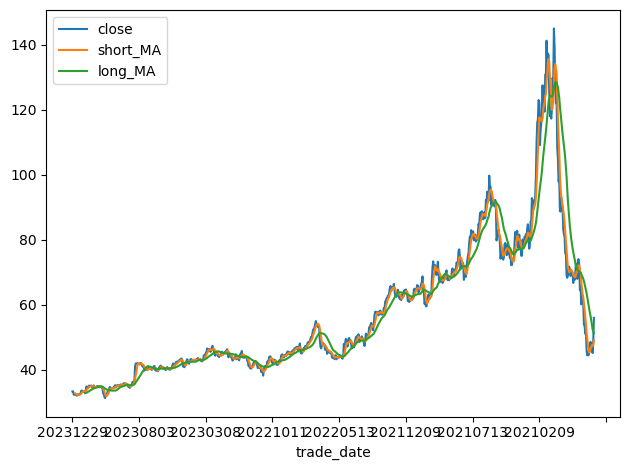

In [6]:
#计算五日平均移动线,也就是短期移动线
df['short_MA'] = df['close'].rolling(window=5).mean()
#计算二十日平均移动线,也就是长期移动线
df['long_MA'] = df['close'].rolling(window=20).mean()
#可视化
df.plot(x='trade_date', y=['close', 'short_MA', 'long_MA'])
plt.tight_layout()
plt.show()

In [7]:
#定义策略函数
def generate_signals(df):
    df['short_MA'] = df['close'].rolling(window=5).mean()
    df['long_MA'] = df['close'].rolling(window=20).mean()
    #形成买入和卖出信号
    #用numpy的where函数来生成信号,如果短期移动线大于长期移动线,则形成买入信号,否则形成卖出信号
    df['signals'] = np.where(df['short_MA'] > df['long_MA'], 1, 0)
    #生成持仓的变化信号,diff的方法会生成每个交易日的持仓变化信号,如果
    #如果Signal从0变为1，这意味着从卖出转为买入，所以Position将为1。
    #如果Signal从1变为0，这意味着从买入转为卖出，所以Position将为-1。
    #如果Signal没有变化，即仍然是0或1，Position将为0，表示持仓没有变化。
    df['position'] = df['signals'].diff()
    return df

In [8]:
df = generate_signals(df)

In [9]:
df['position']

0      NaN
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
778    0.0
779    0.0
780    0.0
781    0.0
782    0.0
Name: position, Length: 783, dtype: float64

In [10]:
#编写回测函数
def backtest_strategy(df):
    df = generate_signals(df)

    # 初始化资本总额
    capital = 100000

    # 初始化每日资本和持仓价值
    daily_capital = capital

    # 初始化持仓变量
    current_position = 0

    # 遍历DataFrame，根据信号进行买卖操作
    for i in range(1, len(df)):
        # 获取当前日期和收盘价
        current_date = df.iloc[i]['trade_date']
        current_close = df.iloc[i]['close']
        # 获取前一天日期和收盘价
        previous_date = df.iloc[i-1]['trade_date']
        previous_close = df.iloc[i-1]['close']
        # 获取前一天持仓变化信号
        previous_position = df.iloc[i-1]['position']

        # 确保日期和收盘价列存在
        if 'trade_date' not in df.columns or 'close' not in df.columns:
            raise ValueError("DataFrame must contain 'trade_date' and 'close' columns.")

        # 根据信号更新持仓
        if previous_position == 0:
            continue
        if previous_position == 1:
            # 如果前一天是买入信号
            buy_price = previous_close
            buy_quantity = daily_capital / buy_price
            daily_capital -= buy_price * buy_quantity
            current_position += buy_quantity

        elif previous_position == -1:
            # 如果前一天是卖出信号
            sell_price = current_close
            sell_quantity = current_position
            daily_capital += sell_price * sell_quantity
            current_position = 0

    # 计算总收益率
    portfolio_value = daily_capital + current_position * current_close
    total_return = (portfolio_value - capital) / capital
    return total_return

In [11]:
#调用回测函数
total_return = backtest_strategy(df)
print(total_return)

0.044149775070931645
